Part 1: Training a naive Random Forest model and Extracting the Most Relevant Genes/Features

ID_REF     1007_s_at  1053_at  117_at  121_at  1255_g_at  1294_at  1316_at  \
GSM767976      11.24     8.55    4.90    2.83       2.08     7.45     7.73   
GSM767977      11.47     8.56    5.89    2.83       2.08     9.80     4.62   
GSM767978      10.95     8.93    6.12    2.43       2.07     6.90     8.11   
GSM767979      11.54     9.52    6.89    2.75       2.07     6.91     7.71   
GSM767980      11.30     8.59    3.39    2.79       2.09     6.69     7.91   

ID_REF     1320_at  1405_i_at  1431_at  ...  AFFX-r2-Ec-bioD-3_at  \
GSM767976     3.07       2.91     4.74  ...                 14.54   
GSM767977     2.31       6.60     6.58  ...                 14.59   
GSM767978     4.06       2.62     4.80  ...                 14.63   
GSM767979     2.67       2.51     5.90  ...                 14.56   
GSM767980     2.67       2.68     2.61  ...                 14.68   

ID_REF     AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
GSM767976                 14.47        

/var/folders/59/lsm98n_n3r50r2_3bqcgq__w0000gn/T/ipykernel_53652/4015668576.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


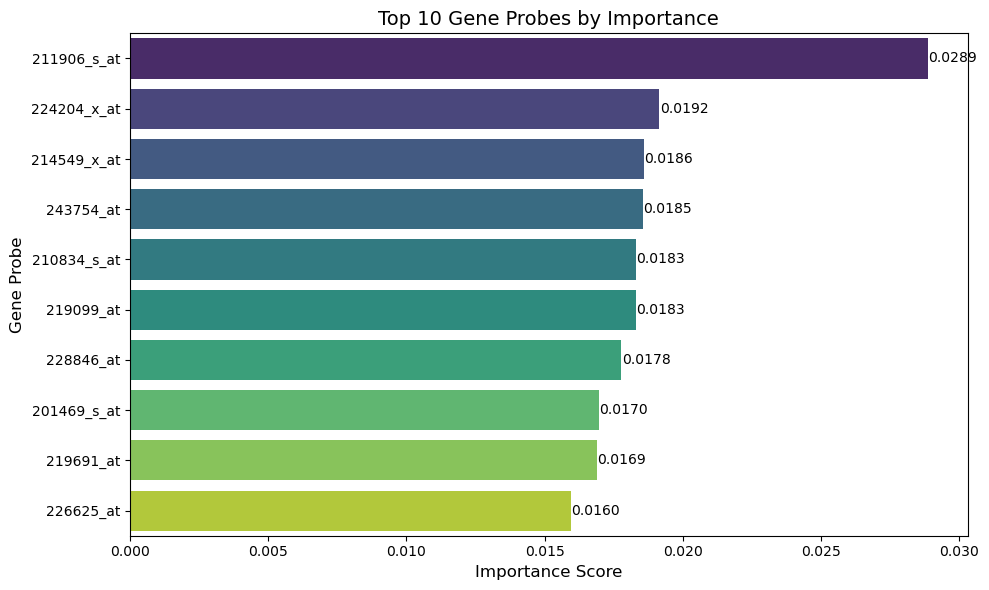

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Load data, format into easier form
expression_matrix_data = pd.read_csv("GSE30999_series_matrix.txt", sep="\t", header=0)
expression_matrix_data = expression_matrix_data.set_index("ID_REF")
expression_matrix_data = expression_matrix_data.transpose()
print(expression_matrix_data.head())

labels_data = pd.read_csv("psoriasislabels.csv", index_col=0)

# Merge the labels with the expression data
merged_data = expression_matrix_data.merge(labels_data, left_index=True, right_index=True)

# Separate features (X) and labels (y)
X = merged_data.drop(columns=["Class"]).values
y = merged_data["Class"].values 

# Normalize expression levels
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test the model
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(f"\nNaive RF model accuracy: {initial_accuracy:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Retrieve feature importance scores, combine with associated genes
feature_importances = rf.feature_importances_
gene_probe_names = expression_matrix_data.columns
importance_df = pd.DataFrame({
    "Gene Probe": gene_probe_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# top 50 genes
top_genes = importance_df.head(50)
print("Top 50 Gene Probes:")
print(top_genes)

# visualize top 10 genes
top_10_genes = top_genes.head(10)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_genes["Importance"], 
    y=top_10_genes["Gene Probe"], 
    palette="viridis"
)
for i, (importance, gene) in enumerate(zip(top_10_genes["Importance"], top_10_genes["Gene Probe"])):
    plt.text(
        importance + 0.00001,
        i,
        f"{importance:.4f}",
        va='center',
        fontsize=10,
        color="black"
    )
plt.title("Top 10 Gene Probes by Importance", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Gene Probe", fontsize=12)
plt.tight_layout()
plt.show()

Part 2: Training a new Random Forest model with the selected features

Accuracy: 0.9705882352941176
Precision: 0.9444444444444444
Recall: 1.0
F1 Score: 0.9714285714285714


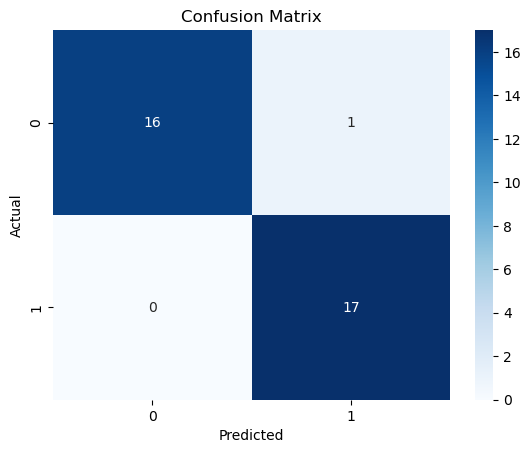

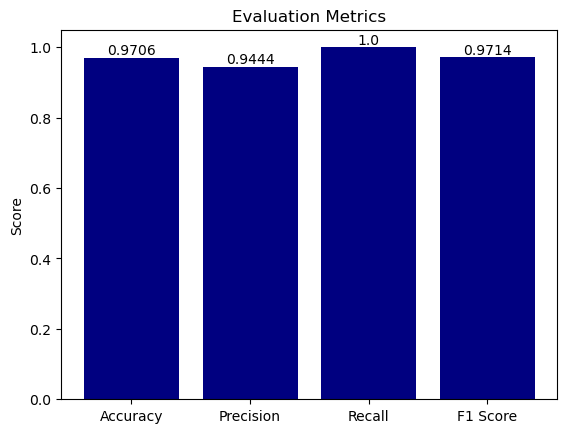

Cross-Validation Scores: [1.         1.         0.97058824 0.97058824 0.97058824]
Mean CV Accuracy: 0.9823529411764707


In [4]:
# Extract top 50 genes, normalize values, split into train-test sets
selected_genes = importance_df.head(50)["Gene Probe"].values
X_selected = expression_matrix_data[selected_genes].values
X_selected_scaled = scaler.fit_transform(X_selected)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_new.fit(X_train_sel, y_train_sel)

# Test and evaluate the model
y_pred_sel = rf_new.predict(X_test_sel)
new_accuracy = accuracy_score(y_test_sel, y_pred_sel)
precision = precision_score(y_test_sel, y_pred_sel)
recall = recall_score(y_test_sel, y_pred_sel)
f1 = f1_score(y_test_sel, y_pred_sel)

print(f"Accuracy: {new_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Metric visualization

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test_sel, y_pred_sel)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar Plot of Metrics
metrics = {
    "Accuracy": new_accuracy,
    "Precision": precision, 
    "Recall": recall, 
    "F1 Score": f1
}
bars = plt.bar(metrics.keys(), metrics.values(), color="navy")
plt.title("Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', color='black')
plt.show()

# Cross-Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_new, X_selected_scaled, y, cv=5, scoring="accuracy")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

Part 3: Hyperparameter Tuning with Grid Search

In [6]:
param_grid = {
    "n_estimators": [5, 10, 25, 50, 100, 150],
    "max_depth": np.arange(1, 11),
    "min_samples_split": [2, 3, 5, 10],
    "min_samples_leaf": [1, 2, 4, 8]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy"
)
grid_search.fit(X_selected_scaled, y)

# Best parameters and model
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model
y_pred_best = best_rf.predict(X_test_sel)

accuracy_best = accuracy_score(y_test_sel, y_pred_best)
precision_best = precision_score(y_test_sel, y_pred_best)
recall_best = recall_score(y_test_sel, y_pred_best)
f1_best = f1_score(y_test_sel, y_pred_best)

print(f"Accuracy: {accuracy_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")
print(f"F1 Score: {f1_best}")

cv_scores_best = cross_val_score(best_rf, X_selected_scaled, y, cv=5, scoring="accuracy")
print(f"Cross-Validation Scores: {cv_scores_best}")
print(f"Mean CV Accuracy: {cv_scores_best.mean()}")

Best Parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Accuracy: 0.9705882352941176
Precision: 0.9444444444444444
Recall: 1.0
F1 Score: 0.9714285714285714
Cross-Validation Scores: [1.         1.         0.97058824 0.97058824 0.97058824]
Mean CV Accuracy: 0.9823529411764707


Part 4: Extended Analysis and Visualization

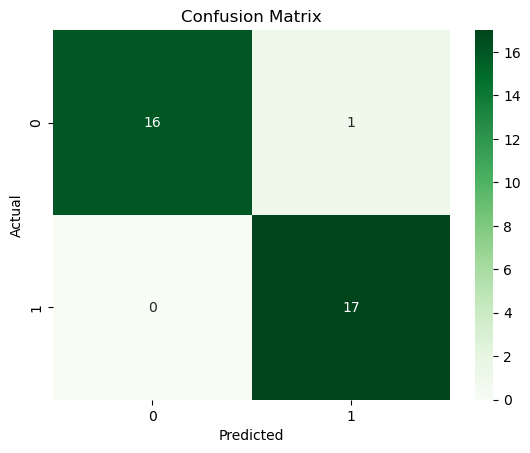

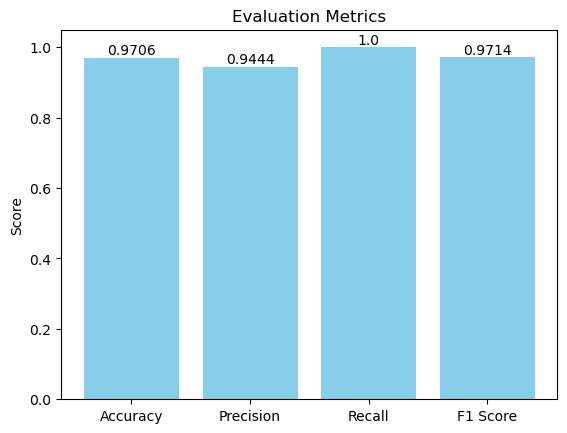

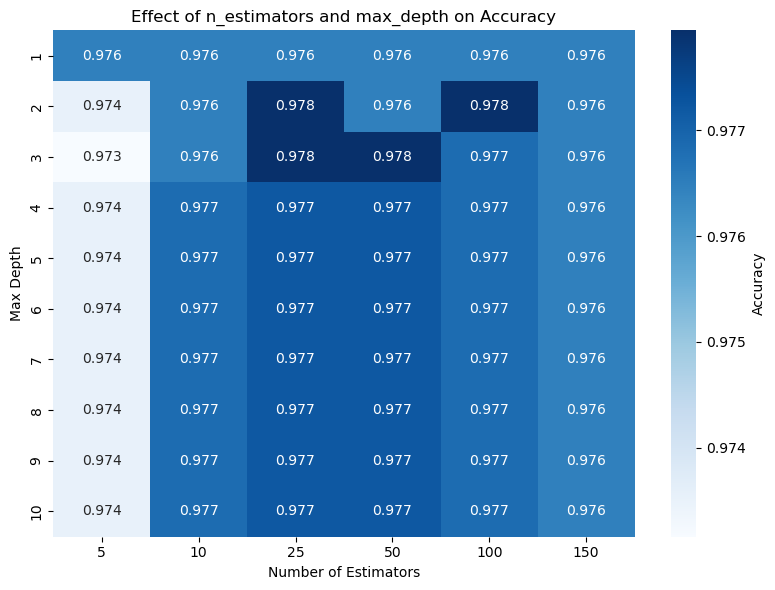

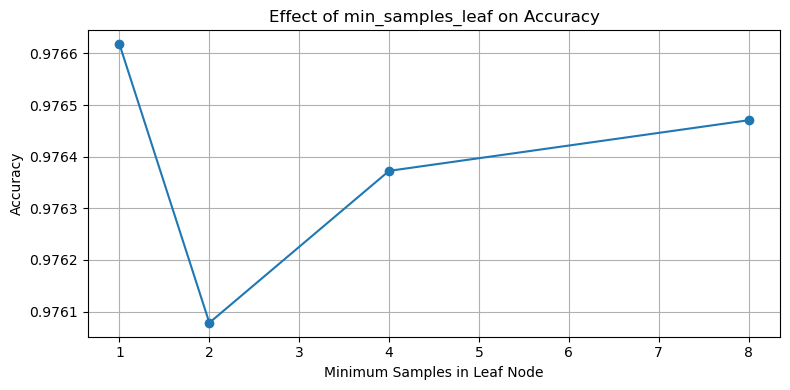

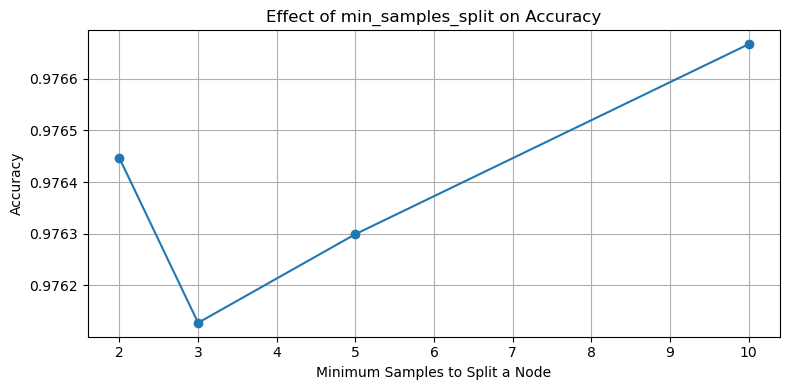

In [8]:
# Confusion Matrix Heatmap
conf_matrix_new = confusion_matrix(y_test_sel, y_pred_best)
sns.heatmap(conf_matrix_new, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar Plot of Metrics
metrics = {
    "Accuracy": accuracy_best,
    "Precision": precision_best, 
    "Recall": recall_best, 
    "F1 Score": f1_best
}
plt.bar(metrics.keys(), metrics.values(), color="skyblue")
plt.title("Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', color='black')
plt.show()



# Hyperparameter analysis

results = pd.DataFrame(grid_search.cv_results_)
results["param_max_depth"] = pd.to_numeric(results["param_max_depth"], errors="coerce")
results["param_n_estimators"] = pd.to_numeric(results["param_n_estimators"], errors="coerce")
results["param_min_samples_split"] = pd.to_numeric(results["param_min_samples_split"], errors="coerce")
results["param_min_samples_leaf"] = pd.to_numeric(results["param_min_samples_leaf"], errors="coerce")
results["mean_test_score"] = pd.to_numeric(results["mean_test_score"], errors="coerce")

# Make heatmap exploring n_estimators and max_depth impact on accuracy

aggregated_results = results.groupby(
    ["param_max_depth", "param_n_estimators"]
)["mean_test_score"].mean().reset_index()

pivot_table = aggregated_results.pivot(
    index="param_max_depth",
    columns="param_n_estimators",
    values="mean_test_score"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="Blues", cbar_kws={"label": "Accuracy"})
plt.title("Effect of n_estimators and max_depth on Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

# Explore effects of min_samples_leaf and min_samples_split on accuracy
leaf_scores = results.groupby("param_min_samples_leaf")["mean_test_score"].mean()

plt.figure(figsize=(8, 4))
plt.plot(leaf_scores.index, leaf_scores.values, marker="o")
plt.title("Effect of min_samples_leaf on Accuracy")
plt.xlabel("Minimum Samples in Leaf Node")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()
plt.show()

split_scores = results.groupby("param_min_samples_split")["mean_test_score"].mean()

plt.figure(figsize=(8, 4))
plt.plot(split_scores.index, split_scores.values, marker="o")
plt.title("Effect of min_samples_split on Accuracy")
plt.xlabel("Minimum Samples to Split a Node")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()
plt.show()